In [1]:
!pip install tensorflow_addons --upgrade

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1_zUFIockLOs5pkGbzEjRU4Em5xvq4ayz', 
                                    dest_path='./bb.zip',
                                    unzip=False)

In [4]:
!unzip bb.zip

Archive:  bb.zip
replace battery_received.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: battery_received.txt    
  inflating: data_received.txt       


In [5]:
!ls

aaaaa.zip  battery_received.txt  bb.zip  data_received.txt  drive  sample_data


In [6]:
folder_name = 'mlp_TSR_Anomaly6'
version = '15'

# Data Wrangling

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [8]:
sns.set_theme()
sns.set_context("paper", font_scale=1.7)

In [9]:
df_sensor = pd.read_csv('data_received.txt')
groups = df_sensor.groupby('ADDR')  
groups_sensor = [groups.get_group(x) for x in groups.groups]

In [10]:
df_sensor

,ADDR,TIME,TID,TEMP,HUM,RSSI
0,6e6d651fbae3,1.573128e+09,203,1991,1119,-63
1,d8896dfe78e4,1.573128e+09,230,1871,1203,-47
2,352299f096d2,1.573128e+09,229,1943,1168,-43
3,e03dbb9965ed,1.573128e+09,226,3370,641,-81
4,c9dc1485bfd2,1.573128e+09,148,1867,1189,-62
...,...,...,...,...,...,...
1277635,b2bac19576cb,1.580143e+09,18,1579,1265,-60
1277636,61cc6cb2b2f8,1.580143e+09,37,2032,1006,-48
1277637,cb578dd18bce,1.580143e+09,70,2007,1414,-63
1277638,8af3d1337ee3,1.580143e+09,80,3945,484,-46


In [11]:
# Merge with battery data

df_batt = pd.read_csv('battery_received.txt')
groups = df_batt.groupby('ADDR')  
groups_batt = [groups.get_group(x) for x in groups.groups]

merged_groups = {} 
for i in range(len(df_batt.ADDR.unique())):
    #VERSION TO USE ONLY TEMP AND HUMIDITY
    #Group Sensor
    groups_sensor_merge = groups_sensor[i].copy()
    #Group Batt
    groups_batt_merge = groups_batt[i].copy()
    
    #Drop first and last values
    n_delete = 60
    groups_sensor_merge.drop(groups_sensor_merge.head(n_delete).index, inplace=True)
    groups_sensor_merge.drop(groups_sensor_merge.tail(n_delete).index, inplace=True)
    groups_batt_merge.drop(groups_batt_merge.head(n_delete).index, inplace=True)
    groups_batt_merge.drop(groups_batt_merge.tail(n_delete).index, inplace=True)
    
    #Fix different lengths
    # REPLACE WITH A TID-BASED FIX IN THE FUTURE IF NEEDED
    if len(groups_sensor_merge) > len(groups_batt_merge):
        groups_sensor_merge.drop(groups_sensor_merge.head(1).index, inplace=True)
    elif len(groups_sensor_merge) < len(groups_batt_merge):
        groups_batt_merge.drop(groups_batt_merge.head(1).index, inplace=True)
    
    #Subsample 1:10
    groups_sensor_merge = groups_sensor_merge.iloc[::10]
    groups_sensor_merge = groups_sensor_merge.reset_index(drop=True)
    groups_batt_merge = groups_batt_merge.iloc[::10]
    groups_batt_merge = groups_batt_merge.reset_index(drop=True)

    print(f'Groups {i}:')
    groups_sensor_merge = groups_sensor_merge.drop(columns=['TIME', 'TID', 'RSSI'])
    addr_sensor = groups_sensor_merge['ADDR'].iloc[0]
    print(f'ADDR sensor: {addr_sensor} | len: {groups_sensor_merge.shape}')
    
    #groups_batt_merge = groups_batt_merge.drop(columns=['TIME', 'TID'])
    addr_batt = groups_batt_merge['ADDR'].iloc[0]
    print(f'ADDR batt:   {addr_batt} | len: {groups_batt_merge.shape}')
       
    #Merge
    groups_merge = groups_sensor_merge.copy()
    groups_sensor_merge['TEMP'] = groups_sensor_merge['TEMP']/100
    groups_sensor_merge['HUM'] = groups_sensor_merge['HUM']/100
    print(f'Group merged shape:              {groups_sensor_merge.shape} \n')
    
    #Add to list
    merged_groups[i] = groups_sensor_merge
    
    
print(f'Len of dict of merged groups: {len(merged_groups)}')
print(f'Shape of first item of dict: {merged_groups[0].shape}')

Groups 0:
ADDR sensor: 149f971bf5c6 | len: (4310, 3)
ADDR batt:   149f971bf5c6 | len: (4310, 4)
Group merged shape:              (4310, 3) 

Groups 1:
ADDR sensor: 24f402b45cde | len: (4217, 3)
ADDR batt:   24f402b45cde | len: (4217, 4)
Group merged shape:              (4217, 3) 

Groups 2:
ADDR sensor: 291fb77414f6 | len: (3191, 3)
ADDR batt:   291fb77414f6 | len: (3191, 4)
Group merged shape:              (3191, 3) 

Groups 3:
ADDR sensor: 2b3951d7d4e5 | len: (4255, 3)
ADDR batt:   2b3951d7d4e5 | len: (4255, 4)
Group merged shape:              (4255, 3) 

Groups 4:
ADDR sensor: 2bfcca8c64e4 | len: (2524, 3)
ADDR batt:   2bfcca8c64e4 | len: (2524, 4)
Group merged shape:              (2524, 3) 

Groups 5:
ADDR sensor: 2ffd9d37a7e8 | len: (4310, 3)
ADDR batt:   2ffd9d37a7e8 | len: (4310, 4)
Group merged shape:              (4310, 3) 

Groups 6:
ADDR sensor: 352299f096d2 | len: (4309, 3)
ADDR batt:   352299f096d2 | len: (4309, 4)
Group merged shape:              (4309, 3) 

Groups 7:
ADD

In [12]:
# Delete unwanted sensor
del merged_groups[32]
del merged_groups[25]
print(f'Len of dict of merged groups: {len(merged_groups)}')
print(merged_groups.keys())

Len of dict of merged groups: 35
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36])


In [13]:
concat_df = pd.concat(merged_groups.values(), ignore_index=True)

In [14]:
# Scale [-1, 1]

# scale range
a = -1
b = 1

# Which are the MAX and MIN of each column??
Max_temp = -9999
Max_humid = -9999

min_temp = 9999
min_humid = 9999

for sensor_df in merged_groups.values():
    sensor_np = sensor_df.drop(columns='ADDR').to_numpy()
    for j in range(len(sensor_np)):
      if sensor_np[j,0] > Max_temp:
          Max_temp = sensor_np[j,0]
      if sensor_np[j,0] < min_temp:
          min_temp = sensor_np[j,0]
          
      if sensor_np[j,1] > Max_humid:
          Max_humid = sensor_np[j,1]
      if sensor_np[j,1] < min_humid:
          min_humid = sensor_np[j,1]

print(f'Max Temp: {Max_temp}')
print(f'min Temp: {min_temp}')
print(' ')

print(f'Max Humid: {Max_humid}')
print(f'min Humid: {min_humid}')
print(' ')

# Scaling between -1 and 1
diff_temp = Max_temp - min_temp
diff_humid = Max_humid - min_humid

scaled_groups = {} 

for i,sensor_df in enumerate(merged_groups.values()):
  sensor_np = sensor_df.drop(columns='ADDR').to_numpy()
  sensor_sc = np.empty(sensor_np.shape)
  for j in range(len(sensor_np)):
    sensor_sc[j,0] = ((b-a)*(sensor_np[j,0] - min_temp) /(diff_temp) ) + a
    sensor_sc[j,1] = ((b-a)*(sensor_np[j,1] - min_humid)/(diff_humid)) + a
  scaled_groups[i] = sensor_sc

print(f'Len of dict of scaled groups: {len(scaled_groups)}')

Max Temp: 46.94
min Temp: 8.14
 
Max Humid: 23.03
min Humid: 3.0
 
Len of dict of scaled groups: 35


In [15]:
# Prepare data to a supervised problem

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return X, y

n_steps_in = 24
n_steps_out = 1

X = []
y = []
label_sensor = []
for i, sensor_np in enumerate(scaled_groups.values()):
    sensor_X, sensor_y = split_sequences(sensor_np, n_steps_in, n_steps_out)
    for j in range(len(sensor_X)):
      label_sensor.append(i)
    X.extend(sensor_X)
    y.extend(sensor_y)
    
X_sc = np.array(X)
y_sc = np.array(y)
label_sc = np.array(label_sensor)
print(X_sc.shape)
print(y_sc.shape)
print(label_sc.shape)

# Number of classes
n_classes = len(np.unique(label_sc))
n_classes

(125763, 24, 2)
(125763, 1, 2)
(125763,)


35

Sensor #18


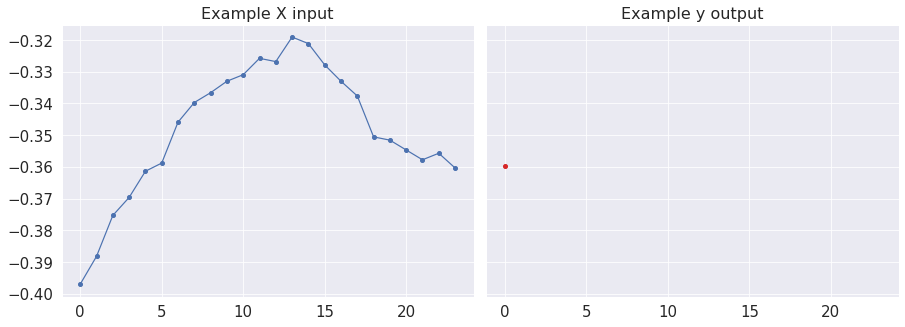

In [16]:
fig,axs = plt.subplots(1,2,sharey=True,sharex=True,figsize=(15,5),
                       gridspec_kw={'wspace': 0.03})
axs[0].plot(X_sc[66666,:,0], marker='.', ms=8)
axs[0].set_title('Example X input', fontsize=16)
axs[1].plot(y_sc[66666,:,0], 'tab:red', marker='.', ms=8)
axs[1].set_title('Example y output', fontsize=16)
print(f'Sensor #{label_sc[66666]}')

In [17]:
dict_variables = {
    0: 'Temp',
    1: 'Humid'
}

# WGAN-GP model

In [18]:
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Dense, Conv1D, BatchNormalization, LSTM, LeakyReLU
from tensorflow.keras.layers import Flatten, Input, Dropout, concatenate, Embedding, Reshape
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.constraints import Constraint
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow import concat
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa
import tensorflow as tf

from astropy import stats

from math import log2, log, isclose

from scipy.special import kl_div, rel_entr
from scipy.spatial.distance import jensenshannon

from sklearn.metrics import r2_score, max_error, mean_absolute_error, mean_squared_error

In [19]:
# define the standalone critic model
def define_critic(in_shape=(25, 2), n_classes=35):
	# weight initialization
	init = RandomNormal(stddev=0.02)
 	# define model
	# input time series
	input_layer = Input(shape=in_shape, name='Time-Series_Input')
	#real_next_ = input_layer[:,-1,:] 
	#real_next_layer = Dense(2)(real_next_)
	# block 1
	x = tfa.layers.SpectralNormalization(Conv1D(64, kernel_size=4, strides=1, padding='same', 
      				kernel_initializer=init))(input_layer)
	x = LeakyReLU(alpha=0.2)(x)
	# block 2
	x = tfa.layers.SpectralNormalization(Conv1D(128, kernel_size=4, strides=1, padding='same', 
                  kernel_initializer=init))(x)
	x = LeakyReLU(alpha=0.2)(x)
	x = Dropout(0.2)(x)
  # block 3
	x = tfa.layers.SpectralNormalization(Conv1D(192, kernel_size=4, strides=1, padding='same', 
                  kernel_initializer=init))(x)
	x = LeakyReLU(alpha=0.2)(x)
	x = Dropout(0.2)(x)
  # block 4
	x = tfa.layers.SpectralNormalization(Conv1D(384, kernel_size=4, strides=1, padding='same', 
                  kernel_initializer=init))(x)
	x = LeakyReLU(alpha=0.2)(x)
	# Dense block
	x = Flatten()(x)
	x = Dense(32)(x)
	x = LeakyReLU(alpha=0.2)(x)
	x = Dropout(0.15)(x)
  # label input
	in_label = Input(shape=(1,), name='Categorical_Input')
	emb_layer = Embedding(n_classes, 8)(in_label) 
	emb_layer = Dense(8)(emb_layer)
	emb_layer = Reshape((8,))(emb_layer)
  # output
	merge_out = concatenate([x, emb_layer])
	out_layer = Dense(16)(merge_out)
	out_layer = LeakyReLU(alpha=0.2)(out_layer)
	out_layer_ = Dense(1, activation='linear')(out_layer)
	model = Model([input_layer, in_label], out_layer_)
	print(model.summary())
	return model

# define the standalone generator model
def define_generator(latent_dim=8, in_shape=(24, 2), n_classes=35):
	# weight initialization
	init = RandomNormal(stddev=0.02)
 	# define model
	# inputs
	in_condition = Input(shape=in_shape, name='Time-Series_Input')
	x = LSTM(160, kernel_initializer=init, return_sequences=True)(in_condition)
	x = BatchNormalization()(x)
	x = LSTM(64, kernel_initializer=init, return_sequences=False)(x)
	x = BatchNormalization()(x)  
  # label input
	in_label = Input(shape=(1,), name='Categorical_Input')
	emb_layer = Embedding(n_classes, 8)(in_label)
	emb_layer = Dense(8)(emb_layer)
	emb_layer = BatchNormalization()(emb_layer)
	emb_layer = Reshape((8,))(emb_layer)
	# noise block
	in_noise = Input(shape=(latent_dim,), name='Noise_Input')
	# merge and dense block
	merge = concatenate([x, emb_layer, in_noise])
	out_layer = Dense(32)(merge)
	out_layer = BatchNormalization()(out_layer)
	out_layer = LeakyReLU(alpha=0.2)(out_layer)
	out_layer_ = Dense(2, activation='linear')(out_layer)
	model = Model([in_condition, in_label, in_noise], out_layer_)
	print(model.summary())
	return model

class WGAN(tf.keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=5,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, labels, real_images, fake_images):
        # both have shape [None, 1, 2]
        # get the interplated image
        alpha = tf.random.normal([batch_size, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator([interpolated, labels], training=True)
        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        # For each batch:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add gradient penalty to the discriminator loss
        # 6. Return generator and discriminator losses as a loss dictionary.
        input_data, labels = real_images
        real_next_ = input_data[:,-1,:] 
        real_next =  backend.expand_dims(real_next_,axis=1) #[None, 1, 2]
        X_cond = input_data[:,:-1,:] #[None, 24, 2]
        # Get the batch size
        batch_size = tf.shape(input_data)[0]
        # Train discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images_ = self.generator([X_cond, labels, random_latent_vectors], training=True)
                fake_images_ = backend.expand_dims(fake_images_,axis=1)
                fake_images = concat([X_cond,fake_images_],axis=1)
                # Get the logits for the fake images
                fake_logits = self.discriminator([fake_images, labels], training=True)
                # Get the logits for real images
                real_logits =self.discriminator([input_data, labels], training=True)

                # Calculate discriminator loss using fake and real logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, labels, input_data, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight
            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )
        # Train the generator now.
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            gen_images_ = self.generator([X_cond, labels, random_latent_vectors], training=True)
            gen_images_ = backend.expand_dims(gen_images_,axis=1)
            generated_images = concat([X_cond,gen_images_],axis=1)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator([generated_images, labels], training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)
        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_test=2500, latent_dim=8, previous_KL=9999, previous_MSE=9999, previous_Pinball=9999):
        self.num_test = num_test
        self.latent_dim = latent_dim
        self.previous_KL = previous_KL
        self.previous_MSE = previous_MSE
        self.previous_Pinball = previous_Pinball
        self.d_hist = list()
        self.g_hist = list()

    def on_train_batch_end(self, batch, logs=None):
      # append losses for visualization later
      self.d_hist.append(logs.get('d_loss'))
      self.g_hist.append(logs.get('g_loss'))

    def on_epoch_end(self, epoch, logs=None):
      previous_KL = self.previous_KL
      previous_MSE = self.previous_MSE
      previous_Pinball = self.previous_Pinball
      step = epoch
      c_model = self.model.discriminator
      g_model = self.model.generator
      latent_dim = self.latent_dim
      n_prediction = 24
      n_plots = 4
      n_samples = X_val_len

      # Get predictions
      X_aux_2 = np.copy(X_val)
      for p in range(n_prediction):
      	noise_input = tf.random.normal(shape=(n_samples, latent_dim))
      	y_gen_ = g_model.predict([X_aux_2, label_val, noise_input]) #Step 1: Predict [val_len,2]
      	y_gen = y_gen_[:,np.newaxis,:] #[val_len,1,2]
      	if p == 0: #Step 2: Save prediction
      	  y_gen_final = y_gen.copy() 
      	else:
      	  y_gen_final = np.concatenate((y_gen_final, y_gen), axis=1)
      	X_aux = X_aux_2[:,1:,:] #Step 3: Put prediction in Condition Time-series
      	X_aux_2 = np.concatenate((X_aux,y_gen), axis=1) 
      
      # invert scale
      y_real_inv = np.empty(y_val_real_long.shape)
      y_gen_inv = np.empty(y_gen_final.shape)
      X_cond_inv = np.empty(X_val.shape)
      for s in range(n_samples):
      	for r in range(n_prediction):
      		y_real_inv[s,r,0] = (y_val_real_long[s,r,0] - a)*(diff_temp/(b-a)) +(min_temp)
      		y_real_inv[s,r,1] = (y_val_real_long[s,r,1] - a)*(diff_humid/(b-a))+(min_humid)
      		y_gen_inv[s,r,0] = (y_gen_final[s,r,0] - a)*(diff_temp/(b-a)) +(min_temp)
      		y_gen_inv[s,r,1] = (y_gen_final[s,r,1] - a)*(diff_humid/(b-a))+(min_humid)
      	for t in range(n_prediction):
      		X_cond_inv[s,t,0] = (X_val[s,t,0] - a)*(diff_temp/(b-a)) +(min_temp)
      		X_cond_inv[s,t,1] = (X_val[s,t,1] - a)*(diff_humid/(b-a))+(min_humid)
        
      temp_real = y_real_inv[:,:,0]
      flat_temp_real = temp_real.flatten()
      temp_gen = y_gen_inv[:,:,0]
      flat_temp_gen = temp_gen.flatten()
      humid_real = y_real_inv[:,:,1]
      flat_humid_real = humid_real.flatten()
      humid_gen = y_gen_inv[:,:,1]
      flat_humid_gen = humid_gen.flatten()

      ### METRICS ###

			# KL divergence with 2D histogram
      H_compute_bins_temp = np.histogram(flat_temp_real, bins='auto')
      H_compute_bins_humid = np.histogram(flat_humid_real, bins='auto')
      n_bins_temp = H_compute_bins_humid[0].shape[0]
      n_bins_humid = H_compute_bins_humid[0].shape[0]
      # If we add more than 2 variables we will need to use np.histogramdd
      H_real, xedges_real, yedges_real = np.histogram2d(flat_temp_real, flat_humid_real, bins=[n_bins_temp,n_bins_humid])
      H_real = (np.where(H_real==0, 1e-6, H_real).flatten())/len(flat_temp_real)
      H_gen, xedges_gen, yedges_gen = np.histogram2d(flat_temp_gen, flat_humid_gen, bins=[n_bins_temp,n_bins_humid])
      H_gen = (np.where(H_gen==0, 1e-6, H_gen).flatten())/len(flat_temp_gen)
      assert isclose(sum(H_real),1.,rel_tol=1e-5)
      assert isclose(sum(H_gen), 1.,rel_tol=1e-5)
      KL_diverg = kl_divergence(H_gen,H_real)

      # Pinball Loss Function
      pinball_temp = list()
      pinball_humid = list()
      tau = [0.1, 0.3, 0.5, 0.7, 0.9]
      for t in tau:
        pinball_temp.append(pinball_func(flat_temp_real, flat_temp_gen, tau=t))
        pinball_humid.append(pinball_func(flat_humid_real, flat_humid_gen, tau=t))

      pinball_mean_temp = sum(pinball_temp)/(len(pinball_temp))
      pinball_mean_humid = sum(pinball_humid)/(len(pinball_humid))
      Pinball_mean = (pinball_mean_temp + pinball_mean_humid)/2

			#MSE
      MSE_temp = mean_absolute_error(flat_temp_real, flat_temp_gen)
      MSE_humid = mean_absolute_error(flat_humid_real, flat_humid_gen)
      MSE_mean = (MSE_temp + MSE_humid)/2

      # random samples fron validation set to plot
      ix_plot = np.random.choice(X_val_range, n_plots, replace=False)

      # save models
      tail_name_kl = ''
      tail_name_pinball = ''
      tail_name_mse = ''
      save_models = False
      print('')
      if (KL_diverg < previous_KL):
      	self.previous_KL = KL_diverg
      	save_models = True
      	tail_name_kl = '_KL'
      	print('Better KL')
      if (Pinball_mean < previous_Pinball):
      	self.previous_Pinball = Pinball_mean
      	save_models = True
      	tail_name_pinball = '_Pinball'
      	print('Better Pinball')
      if (MSE_mean < previous_MSE):
      	self.previous_MSE = MSE_mean
      	save_models = True
      	tail_name_mse = '_MSE'
      	print('Better MSE')
      # EAAI
      if step%50==0:
      	save_models = True
      	tail_name_mse = '_50s'
      	print('Save each 50 steps')
      # EAAI
      if save_models == True:
        filename_critic = '/content/drive/My Drive/TFM/Experiments/'+folder_name+'/'+'c_model_'+str(step+1)+tail_name_kl+tail_name_pinball+tail_name_mse
        c_model.save_weights(filename_critic)
        filename_generator = '/content/drive/My Drive/TFM/Experiments/'+folder_name+'/'+'gen_model_'+str(step+1)+tail_name_kl+tail_name_pinball+tail_name_mse
        g_model.save_weights(filename_generator)
        print(f'>{step+1} MODELS HAVE BEEN SAVED')
        # save data
        filename = '/content/drive/My Drive/TFM/Experiments/'+folder_name+'/'+str(step+1)+'_temp_real.npy'
        np.save(filename, temp_real)
        filename = '/content/drive/My Drive/TFM/Experiments/'+folder_name+'/'+str(step+1)+'_temp_gen.npy'
        np.save(filename, temp_gen)
        filename = '/content/drive/My Drive/TFM/Experiments/'+folder_name+'/'+str(step+1)+'_humid_real.npy'
        np.save(filename, humid_real)
        filename = '/content/drive/My Drive/TFM/Experiments/'+folder_name+'/'+str(step+1)+'_humid_gen.npy'
        np.save(filename, humid_gen)
        # plot images and metrics
        for num, i in enumerate(ix_plot):
          for j in range(dim_n_vars):
            fig,axs = plt.subplots(1,dim_n_vars,sharey=True,sharex=True,figsize=(15,5),gridspec_kw={'wspace': 0.03})
            axs[0].plot(X_cond_inv[i,:,j], marker='.', ms=8)
            name = dict_variables[j] + ' - Input'
            axs[0].set_title(name, fontsize=16)
            axs[1].plot(y_real_inv[i,:,j], marker='.', ms=8)
            axs[1].plot(y_gen_inv[i,:,j], 'tab:red', marker='.', ms=8)
            axs[1].set_title('Output (red: predicted)', fontsize=16)
            filename_img = '/content/drive/My Drive/TFM/Experiments/'+folder_name+'/'+str(step+1)+'_'+str(i)+'_'+str(dict_variables[j])+'.png'
            plt.savefig(filename_img)
            plt.show()
            plt.close()
            print(f'Sensor #{label_val[i]}')
            print(dict_variables[j])
						# mean absolute error ± standard deviation
            error_np = np.subtract(y_real_inv[i,:,j], y_gen_inv[i,:,j])
            mae = mean_absolute_error(y_real_inv[i,:,j], y_gen_inv[i,:,j])
            std = np.std(error_np)
            print(f'MAE: {mae} ± {std}') 
            # mean squared error
            mse = mean_squared_error(y_real_inv[i,:,j], y_gen_inv[i,:,j])
            print(f'MSE: {mse}') 
						# root mean square error
            rmse = np.sqrt(mse)
            print(f'RMSE: {rmse}') 
						# max error
            max_err = max_error(y_real_inv[i,:,j], y_gen_inv[i,:,j])
            print(f'Max Error: {max_err}') 
      #Print global metrics
      print(f'\nKL Divergence: {KL_diverg} bits')
      print(f'Pinball Loss Temp mean: {pinball_mean_temp}')
      print(f'Pinball Loss Humid mean: {pinball_mean_humid}')
      print(f'MSE Temp: {MSE_temp}')
      print(f'MSE Humid: {MSE_humid}')
      # plot histograms
      fig,axs = plt.subplots(1,dim_n_vars,sharey=True,sharex=True,figsize=(12,4),gridspec_kw={'wspace': 0.03})
      #axs[0].hist(flat_temp_real, bins='auto')
      axs[0].set_title('Temp Real Distribution', fontsize=14)
      sns.histplot(flat_temp_real, bins=n_bins_temp, ax=axs[0])
      #axs[1].hist(flat_temp_gen, bins='auto')
      axs[1].set_title('Temp Generated Distribution', fontsize=14)
      sns.histplot(flat_temp_gen, bins=n_bins_temp, ax=axs[1])
      filename_img = '/content/drive/My Drive/TFM/Experiments/'+folder_name+'/'+str(step+1)+'_histogram_temp.png'
      plt.savefig(filename_img)
      plt.show()
      plt.close()
      fig,axs = plt.subplots(1,dim_n_vars,sharey=True,sharex=True,figsize=(12,4),gridspec_kw={'wspace': 0.03})
      #axs[0].hist(flat_humid_real, bins='auto')
      axs[0].set_title('Humid Real Distribution', fontsize=14)
      sns.histplot(flat_humid_real, bins=n_bins_humid, ax=axs[0])
      #axs[1].hist(flat_humid_gen, bins='auto')
      axs[1].set_title('Humid Generated Distribution', fontsize=14)
      sns.histplot(flat_humid_gen, bins=n_bins_humid, ax=axs[1])
      filename_img = '/content/drive/My Drive/TFM/Experiments/'+folder_name+'/'+str(step+1)+'_histogram_humid.png'
      plt.savefig(filename_img)
      plt.show()
      plt.close()
      # plot and save history
      plot_history(self.d_hist, self.g_hist, step)

# pinball loss function [https://www.tensorflow.org/addons/api_docs/python/tfa/losses/pinball_loss]
def pinball_func(y_true, y_pred, tau):
	values = list()
	for l in range(len(y_true)):
		values.append(max(tau*(y_true[l] - y_pred[l]), (tau - 1)*(y_true[l] - y_pred[l])))
	return (sum(values)/len(values))

# calculate the kl divergence in bits
def kl_divergence(p,q):
	return sum((p[i] * log2(p[i]/q[i]) for i in range(len(p))))

# calculate the kl divergence in nats
def kl_divergence_nats(p,q):
	return sum((p[i] * log(p[i]/q[i]) for i in range(len(p))))

# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist, step):
	# plot history
	filename = '/content/drive/My Drive/TFM/Experiments/'+folder_name+'/'+'final_d_hist.npy'
	np.save(filename, d_hist)
	filename = '/content/drive/My Drive/TFM/Experiments/'+folder_name+'/'+'final_g_hist.npy'
	np.save(filename, g_hist)
	plt.plot(d_hist, label='crit')
	plt.plot(g_hist, label='gen')
	plt.legend()
	#pyplot.savefig('plot_line_plot_loss.png')
	#pyplot.close()
	filename = '/content/drive/My Drive/TFM/Experiments/'+folder_name+'/'+str(step+1)+'_final_train_loss.png'
	plt.savefig(filename)
	plt.show()
	plt.close()
 
# Define the loss functions to be used for discrimiator
# This should be (fake_loss - real_loss)
# We will add the gradient penalty later to this loss function
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

# Define the loss functions to be used for generator
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

In [20]:
# AdaBelief optimizer
!pip install adabelief-tf==0.1.0

In [21]:
from adabelief_tf import AdaBeliefOptimizer
d_opt_AdaBelief = AdaBeliefOptimizer(learning_rate=1e-2, epsilon=1e-10, rectify=False, weight_decay=1.2e-6)
g_opt_AdaBelief = AdaBeliefOptimizer(learning_rate=3.3e-3, epsilon=1e-10, rectify=False, weight_decay=1.2e-6)

Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
Current version (0.1.0)  1e-14  supported          default: True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
Current version (0.1.0)  1e-14  supported          default: True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer



# Synthetic data generation

In [22]:
latent_dim = 8

selected_generator = define_generator(latent_dim=latent_dim, in_shape=(24, 2), n_classes=35)

model_gen_name = '/content/drive/My Drive/TFM/Experiments/gen_model_45_KL_Pinball_MSE'

selected_generator.load_weights(model_gen_name)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Time-Series_Input (InputLayer)  [(None, 24, 2)]     0           []                               
                                                                                                  
 Categorical_Input (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 24, 160)      104320      ['Time-Series_Input[0][0]']      
                                                                                                  
 embedding (Embedding)          (None, 1, 8)         280         ['Categorical_Input[0][0]']      
                                                                                              

In [23]:
n_samples = 15000
n_scenarios = 10
n_prediction = 25

random_seed = 73
rng = np.random.default_rng(random_seed)

X_len = len(X_sc)

# Get historical values and val/test values
n_real_val = int(n_samples*0.15)
n_real_test = int(n_samples*0.2)

ix_gen = rng.choice(X_len, n_samples+n_real_val+n_real_test, replace=False)

ix_history = ix_gen[:n_samples]
ix_val = ix_gen[n_samples : n_samples+n_real_val]
ix_test = ix_gen[n_samples+n_real_val : n_samples+n_real_val+n_real_test]

X_cond = np.copy(X_sc[ix_history])
X_label = np.copy(label_sc[ix_history])

step_anomaly = 20
n_anomalies = int(n_samples*0.1)
n_normal = n_samples - n_anomalies
# Get predictions
# Final shape: [n_samples, n_scenarios, lenght, 2]
for scen in range(n_scenarios):
  X_aux_2 = np.copy(X_cond)
  for p in range(n_prediction):
    if p == step_anomaly:
      noise_anom = tf.random.normal(shape=(n_anomalies, latent_dim), mean=0.0, stddev=11)
      noise_normal = tf.random.normal(shape=(n_normal, latent_dim), mean=0.0, stddev=1.8)
      noise_input = np.concatenate((noise_anom, noise_normal))
      rng.shuffle(noise_input)
    else:
      noise_input = tf.random.normal(shape=(n_samples, latent_dim), mean=0.0, stddev=1.8)
    y_gen_ = selected_generator.predict([X_aux_2, X_label, noise_input]) #Step 1: Predict [n_samples,2]
    y_gen = y_gen_[:,np.newaxis,:] #[n_samples,1,2]
    if p == 0: #Step 2: Save prediction
      y_gen_final = np.copy(y_gen)
    else:
      y_gen_final = np.concatenate((y_gen_final, y_gen), axis=1)
    X_aux = X_aux_2[:,1:,:] #Step 3: Put prediction in Condition Time-series
    X_aux_2 = np.concatenate((X_aux,y_gen), axis=1) 
  y_gen_final_aux = y_gen_final[:, np.newaxis, :, :]
  if scen == 0:
    y_gen_final_final = np.copy(y_gen_final_aux)
  else:
    y_gen_final_final = np.concatenate((y_gen_final_final, y_gen_final_aux), axis=1)

print(f'y generated shape: {y_gen_final_final.shape}') #shape: [20, 10, 24, 2]
'''
# invert scale
y_gen_inv = np.empty(y_gen_final_final.shape)
#generated
for s in range(n_samples): 
  for q in range(n_scenarios): 
    for r in range(n_prediction): 
      y_gen_inv[s,q,r,0] = (y_gen_final_final[s,q,r,0] - a)*(diff_temp/(b-a)) +(min_temp)
      y_gen_inv[s,q,r,1] = (y_gen_final_final[s,q,r,1] - a)*(diff_humid/(b-a))+(min_humid)

'''

y_gen_inv = np.copy(y_gen_final_final)
print(y_gen_inv.shape)

y generated shape: (15000, 10, 25, 2)
(15000, 10, 25, 2)


In [24]:
# Convert synthetic data to supervised problem to train a prediction model
new_shape = (y_gen_inv.shape[0]*y_gen_inv.shape[1], y_gen_inv.shape[2], y_gen_inv.shape[3])
data_gen = np.reshape(y_gen_inv, new_shape)
filename = '/content/drive/My Drive/TFM/Experiments/APIN/'+folder_name+'/data_gen.npy'
np.save(filename, data_gen)
print(f'Gen data shape: {data_gen.shape}')

# Sensor ID labels
X_pred_labels = np.repeat(X_label, n_scenarios)

X_pred = np.empty((data_gen.shape[0], n_prediction-1, 2))
y_pred = np.empty((data_gen.shape[0], 1, 2))

for m in range(data_gen.shape[0]):
  X_pred[m] = data_gen[m,:n_prediction-1,:]
  y_pred[m] = data_gen[m,-1,:]

print(X_pred.shape)
print(y_pred.shape)
print(X_pred_labels.shape)

Gen data shape: (150000, 25, 2)
(150000, 24, 2)
(150000, 1, 2)
(150000,)


In [25]:
# Validation and test datasets from real data
X_val = np.copy(X_sc[ix_val])
y_val = np.copy(y_sc[ix_val])
X_label_val = np.copy(label_sc[ix_val])

X_test = np.copy(X_sc[ix_test])
y_test = np.copy(y_sc[ix_test])
X_label_test = np.copy(label_sc[ix_test])

print(f'X_val: {X_val.shape}')
print(f'y_val: {y_val.shape}')
print(f'X_label_val: {X_label_val.shape}')
print('')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')
print(f'X_label_test: {X_label_test.shape}')

X_val: (2250, 24, 2)
y_val: (2250, 1, 2)
X_label_val: (2250,)

X_test: (3000, 24, 2)
y_test: (3000, 1, 2)
X_label_test: (3000,)


# (TS+R)TR


## Train Synthetic + Real

In [26]:
from sklearn.model_selection import train_test_split

random_seed = 73

list_ix_real = list(range(0,X_sc.shape[0]))

# Train: 75%
# Val: 10%
# Test: 15%
train_ix, val_test_ix = train_test_split(list_ix_real, 
                                                                 test_size=0.25, 
                                                                 train_size=0.75, 
                                                                 random_state=random_seed)
val_ix, test_ix = train_test_split(val_test_ix, 
                                                           test_size=0.60, 
                                                           train_size=0.40, 
                                                           random_state=random_seed)

print(f'len(train_ix): {len(train_ix)}')
print(f'len(val_ix): {len(val_ix)}')
print(f'len(test_ix): {len(test_ix)}')

len(train_ix): 94322
len(val_ix): 12576
len(test_ix): 18865


In [27]:
X_real = X_sc[train_ix]
X_real_val = X_sc[val_ix]
X_real_test = X_sc[test_ix]

y_real = y_sc[train_ix]
y_real_val = y_sc[val_ix]
y_real_test = y_sc[test_ix]

print(f'X_real: {X_real.shape}')
print(f'y_real: {y_real.shape}')
print('')
print(f'X_real_val: {X_real_val.shape}')
print(f'y_real_val: {y_real_val.shape}')
print('')
print(f'X_real_test: {X_real_test.shape}')
print(f'y_real_test: {y_real_test.shape}')

X_real: (94322, 24, 2)
y_real: (94322, 1, 2)

X_real_val: (12576, 24, 2)
y_real_val: (12576, 1, 2)

X_real_test: (18865, 24, 2)
y_real_test: (18865, 1, 2)


Text(0.5, 1.0, 'Example Temp output')

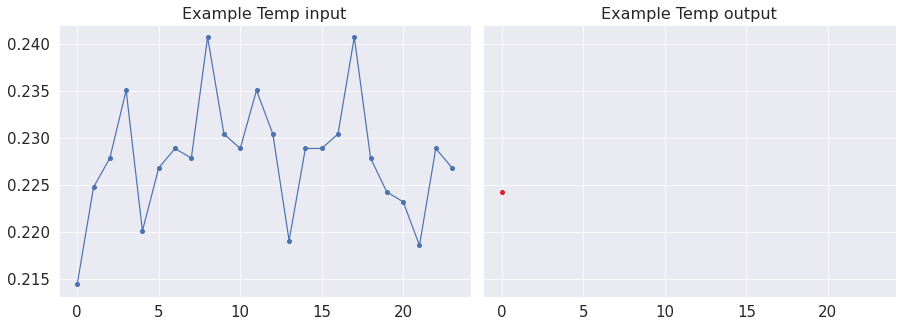

In [28]:
fig,axs = plt.subplots(1,2,sharey=True,sharex=True,figsize=(15,5),
                       gridspec_kw={'wspace': 0.03})
axs[0].plot(X_real[600,:,0], marker='.', ms=8)
axs[0].set_title('Example Temp input', fontsize=16)
axs[1].plot(y_real[600,:,0], 'tab:red', marker='.', ms=8)
axs[1].set_title('Example Temp output', fontsize=16)

In [29]:
X_real_flat = np.reshape(X_real, (X_real.shape[0], X_real.shape[1]*X_real.shape[2]))
y_real_flat = np.reshape(y_real, (y_real.shape[0], y_real.shape[1]*y_real.shape[2]))
X_real_val_flat = np.reshape(X_real_val, (X_real_val.shape[0], X_real_val.shape[1]*X_real_val.shape[2]))
y_real_val_flat = np.reshape(y_real_val, (y_real_val.shape[0], y_real_val.shape[1]*y_real_val.shape[2]))
X_real_test_flat = np.reshape(X_real_test, (X_real_test.shape[0], X_real_test.shape[1]*X_real_test.shape[2]))
y_real_test_flat = np.reshape(y_real_test, (y_real_test.shape[0], y_real_test.shape[1]*y_real_test.shape[2]))

print(f'X_real_flat: {X_real_flat.shape}')
print(f'y_real_flat: {y_real_flat.shape}')
print('')
print(f'X_real_val_flat: {X_real_val_flat.shape}')
print(f'y_real_val_flat: {y_real_val_flat.shape}')
print('')
print(f'X_real_test_flat: {X_real_test_flat.shape}')
print(f'y_real_test_flat: {y_real_test_flat.shape}')

X_real_flat: (94322, 48)
y_real_flat: (94322, 2)

X_real_val_flat: (12576, 48)
y_real_val_flat: (12576, 2)

X_real_test_flat: (18865, 48)
y_real_test_flat: (18865, 2)


In [30]:
# Synthetic Data
X_pred_flat = np.reshape(X_pred, (X_pred.shape[0], X_pred.shape[1]*X_pred.shape[2]))
y_pred_flat = np.reshape(y_pred, (y_pred.shape[0], y_pred.shape[1]*y_pred.shape[2]))

print(f'X_pred_flat: {X_pred_flat.shape}')
print(f'y_pred_flat: {y_pred_flat.shape}')

X_pred_flat: (150000, 48)
y_pred_flat: (150000, 2)


In [31]:
# Merge Synthetic and Real
X_TRS = np.concatenate((X_real_flat, X_pred_flat))
y_TRS = np.concatenate((y_real_flat, y_pred_flat))
#shuffle
idx_TRS = np.arange(0,X_TRS.shape[0])
rng.shuffle(idx_TRS)
X_TRS = X_TRS[idx_TRS]
y_TRS = y_TRS[idx_TRS]

print(f'X_TRS: {X_TRS.shape}')
print(f'y_TRS: {y_TRS.shape}')

X_TRS: (244322, 48)
y_TRS: (244322, 2)


In [32]:
inputs = tf.keras.layers.Input(shape=X_TRS.shape[1])
x = tf.keras.layers.Dense(256, activation='relu')(inputs)
x = tf.keras.layers.Dense(32, activation='relu')(x)
outputs = tf.keras.layers.Dense(2)(x)

model_real = Model(inputs=inputs, outputs=outputs)
opt=tf.keras.optimizers.Adam()
model_real.compile(optimizer=opt, loss='mse')
model_real.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48)]              0         
                                                                 
 dense_3 (Dense)             (None, 256)               12544     
                                                                 
 dense_4 (Dense)             (None, 32)                8224      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 20,834
Trainable params: 20,834
Non-trainable params: 0
_________________________________________________________________


In [33]:
n_epochs = 100
batch = 72

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

history = model_real.fit(X_TRS, y_TRS, 
                    epochs=n_epochs, 
                    batch_size=batch, 
                    validation_data=(X_real_val_flat, y_real_val_flat), 
                    shuffle=True,
                    callbacks=es_callback)

Epoch 1/100
3394/3394 [==============================] - 9s 3ms/step - loss: 5.3111e-04 - val_loss: 1.6595e-04
Epoch 2/100
3394/3394 [==============================] - 8s 2ms/step - loss: 1.0794e-04 - val_loss: 1.7044e-04
Epoch 3/100
3394/3394 [==============================] - 8s 2ms/step - loss: 9.1351e-05 - val_loss: 1.5942e-04
Epoch 4/100
3394/3394 [==============================] - 8s 2ms/step - loss: 8.4262e-05 - val_loss: 1.9805e-04
Epoch 5/100
3394/3394 [==============================] - 8s 2ms/step - loss: 7.9957e-05 - val_loss: 1.9071e-04
Epoch 6/100
3394/3394 [==============================] - 8s 2ms/step - loss: 7.6485e-05 - val_loss: 1.8060e-04
Epoch 7/100
3394/3394 [==============================] - 8s 2ms/step - loss: 7.3042e-05 - val_loss: 1.2808e-04
Epoch 8/100
3394/3394 [==============================] - 8s 2ms/step - loss: 7.1754e-05 - val_loss: 1.6643e-04
Epoch 9/100
3394/3394 [==============================] - 8s 2ms/step - loss: 6.9900e-05 - val_loss: 1.2322e-04
E

In [34]:
model_real.evaluate(X_real_test_flat, y_real_test_flat)

590/590 [==============================] - 1s 2ms/step - loss: 1.2831e-04


0.00012830854393541813

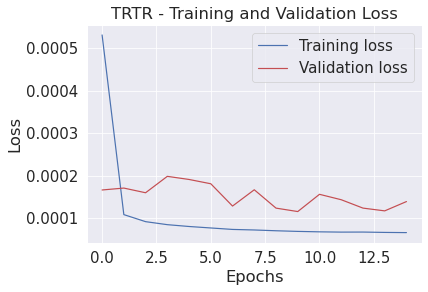

In [35]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "TRTR - Training and Validation Loss")


In [36]:
filename_model = '/content/drive/My Drive/TFM/Experiments/APIN/'+ folder_name +'/TRSmlp_model_'+version
model_real.save_weights(filename_model)
# save data
filename = '/content/drive/My Drive/TFM/Experiments/APIN/'+ folder_name +'/X_pred.npy'
np.save(filename, X_pred)
filename = '/content/drive/My Drive/TFM/Experiments/APIN/'+ folder_name +'/y_pred.npy'
np.save(filename, y_pred)
filename = '/content/drive/My Drive/TFM/Experiments/APIN/'+ folder_name +'/X_real.npy'
np.save(filename, X_real)
filename = '/content/drive/My Drive/TFM/Experiments/APIN/'+ folder_name +'/y_real.npy'
np.save(filename, y_real)
filename = '/content/drive/My Drive/TFM/Experiments/APIN/'+ folder_name +'/X_real_val.npy'
np.save(filename, X_real_val)
filename = '/content/drive/My Drive/TFM/Experiments/APIN/'+ folder_name +'/y_real_val.npy'
np.save(filename, y_real_val)
filename = '/content/drive/My Drive/TFM/Experiments/APIN/'+ folder_name +'/X_real_test.npy'
np.save(filename, X_real_test)
filename = '/content/drive/My Drive/TFM/Experiments/APIN/'+ folder_name +'/y_real_test.npy'
np.save(filename, y_real_test)

## Test Real

In [37]:
y_real_hat = model_real.predict(X_real_test_flat)

# invert scale
y_real_hat_inv = np.empty(y_real_hat.shape)
for s in range(y_real_hat.shape[0]): 
  y_real_hat_inv[s,0] = (y_real_hat[s,0] - a)*(diff_temp/(b-a)) +(min_temp)
  y_real_hat_inv[s,1] = (y_real_hat[s,1] - a)*(diff_humid/(b-a))+(min_humid)

y_real_test_inv = np.empty(y_real_test_flat.shape)
for s in range(y_real_test_flat.shape[0]): 
  y_real_test_inv[s,0] = (y_real_test_flat[s,0] - a)*(diff_temp/(b-a)) +(min_temp)
  y_real_test_inv[s,1] = (y_real_test_flat[s,1] - a)*(diff_humid/(b-a))+(min_humid)

mse_temp = sklearn.metrics.mean_squared_error(y_real_test_inv[:,0], y_real_hat_inv[:,0])
print(f'MSE Temp: {mse_temp}')
mse_humid = sklearn.metrics.mean_squared_error(y_real_test_inv[:,1], y_real_hat_inv[:,1])
print(f'MSE Humid: {mse_humid}')

rmse_temp = sklearn.metrics.mean_squared_error(y_real_test_inv[:,0], y_real_hat_inv[:,0], squared = False)
print(f'RMSE Temp: {rmse_temp}')
rmse_humid = sklearn.metrics.mean_squared_error(y_real_test_inv[:,1], y_real_hat_inv[:,1], squared = False)
print(f'RMSE Humid: {rmse_humid}')

MSE Temp: 0.05327777433385505
MSE Humid: 0.011540171244997618
RMSE Temp: 0.23081978756998944
RMSE Humid: 0.10742518906195891


In [38]:
y_real_hat_inv[60]

array([20.61044668, 14.77480214])

In [39]:
y_real_test_inv[60]

array([20.12, 15.13])

In [40]:
filename = '/content/drive/My Drive/TFM/Experiments/APIN/'+ folder_name +'/y_real_test_inv.npy'
np.save(filename, y_real_test_inv)
filename = '/content/drive/My Drive/TFM/Experiments/APIN/'+ folder_name +'/y_real_hat_inv.npy'
np.save(filename, y_real_hat_inv)

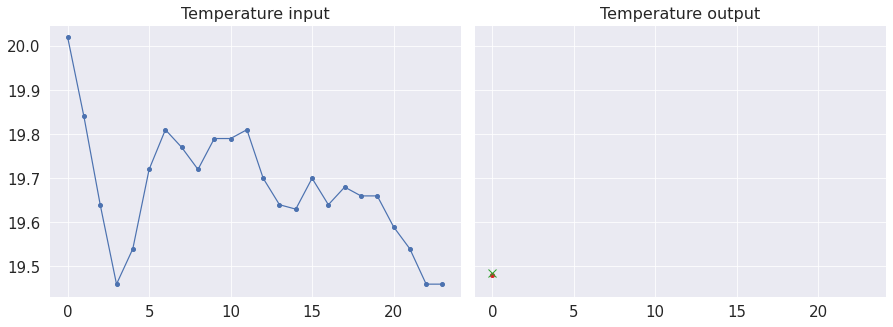

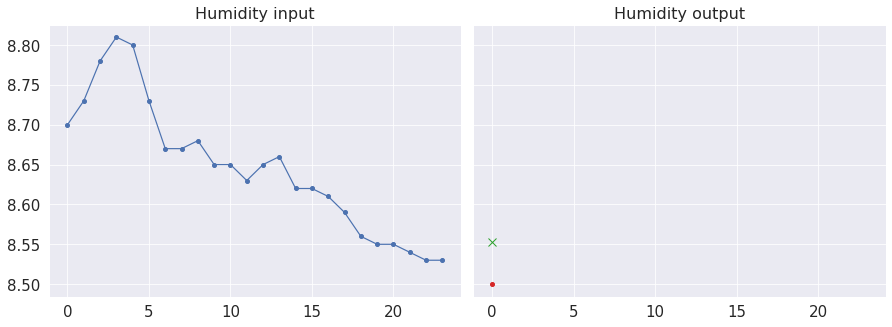

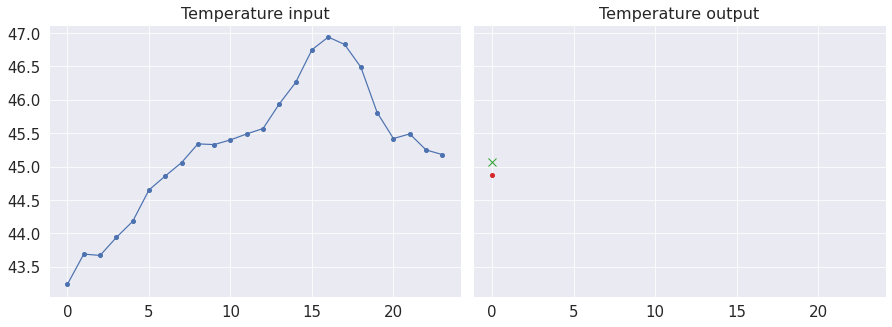

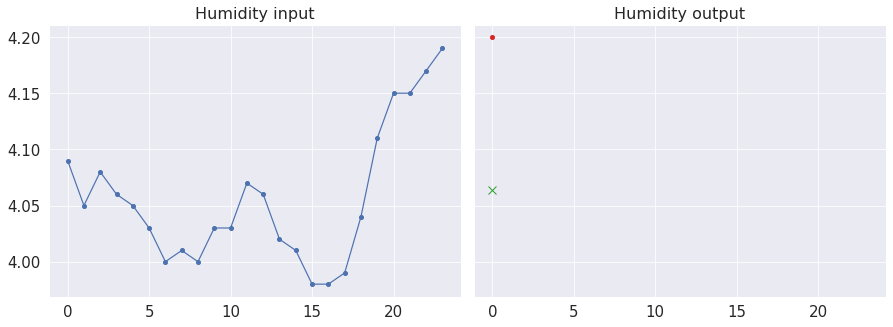

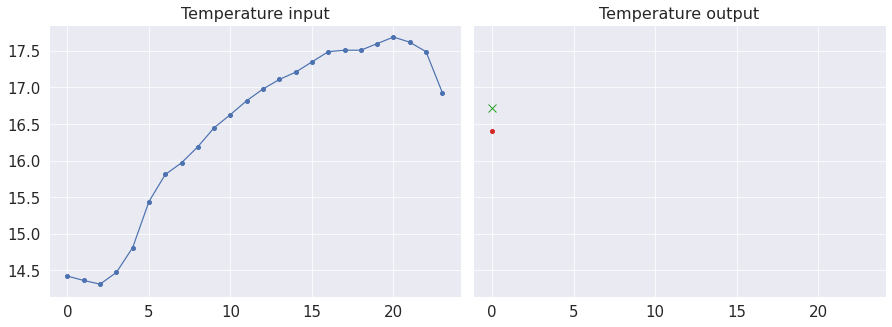

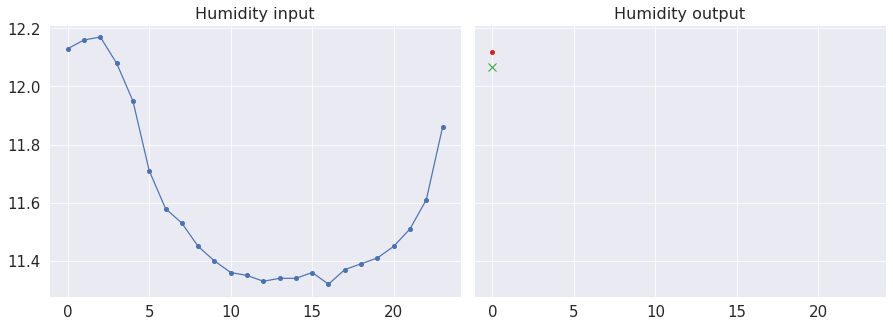

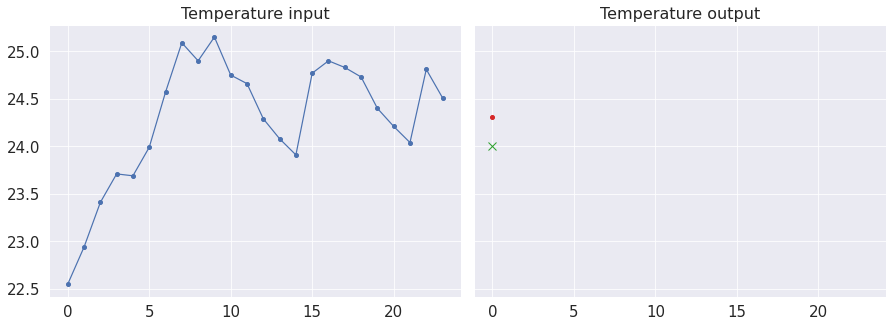

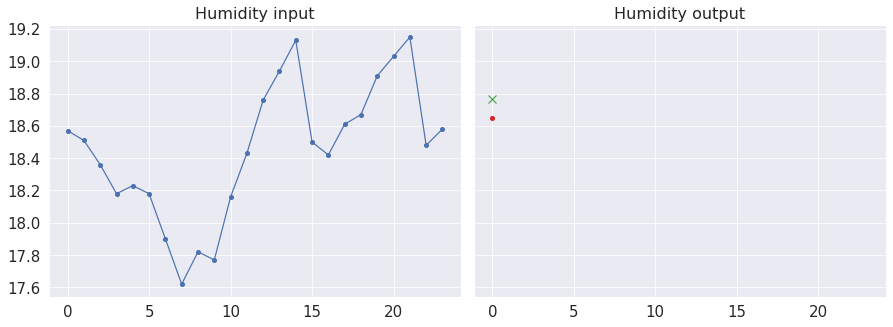

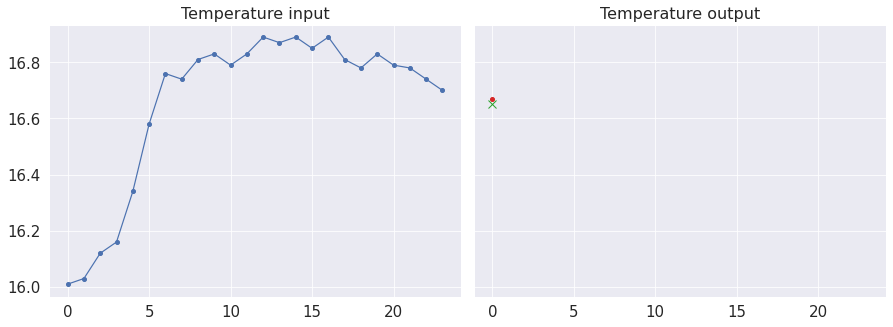

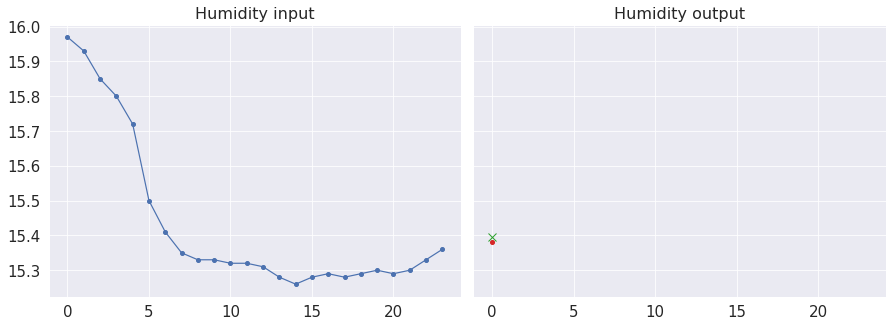

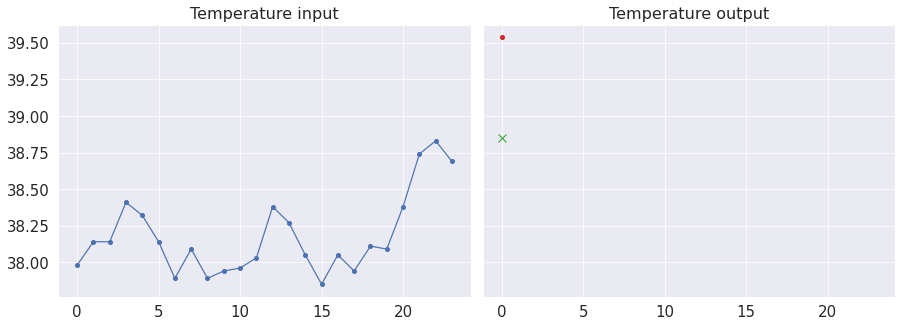

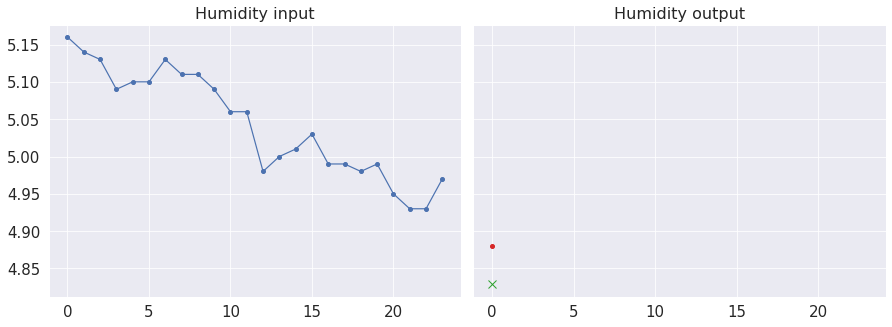

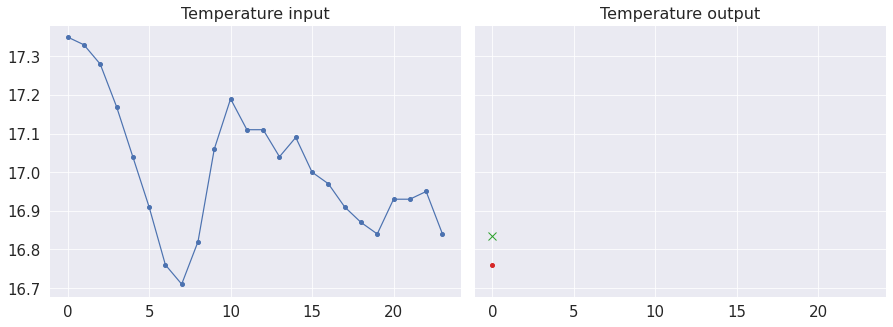

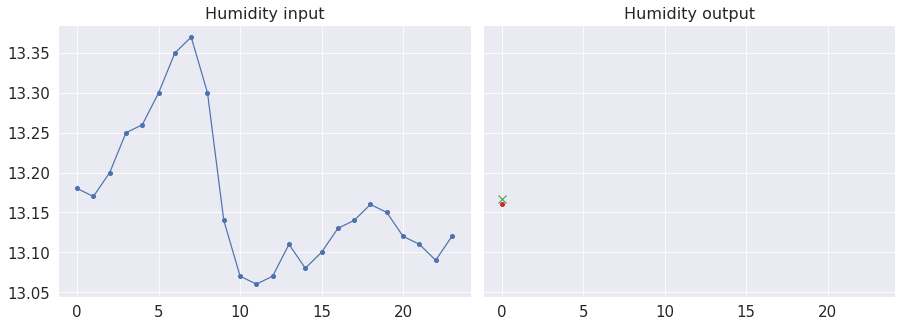

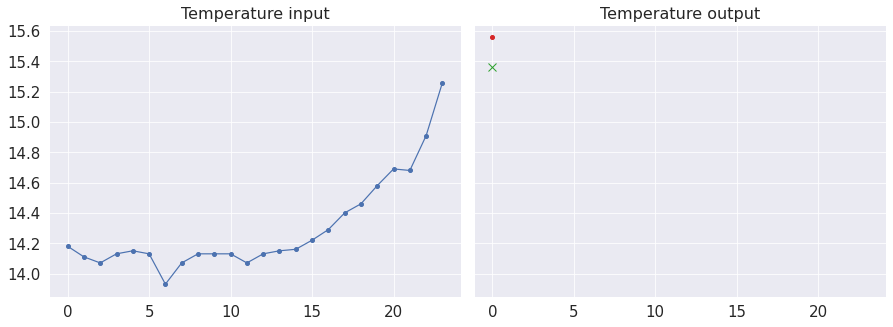

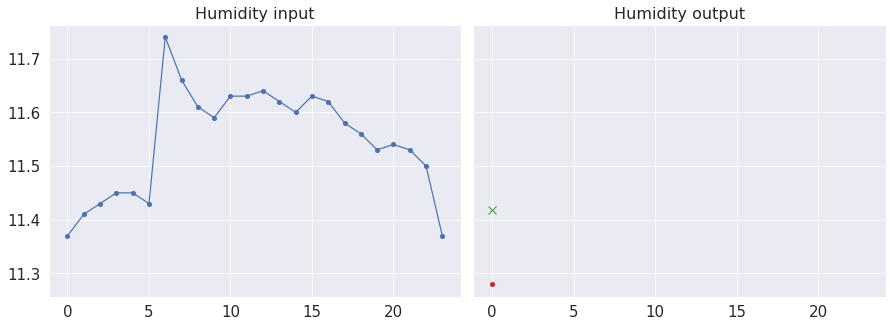

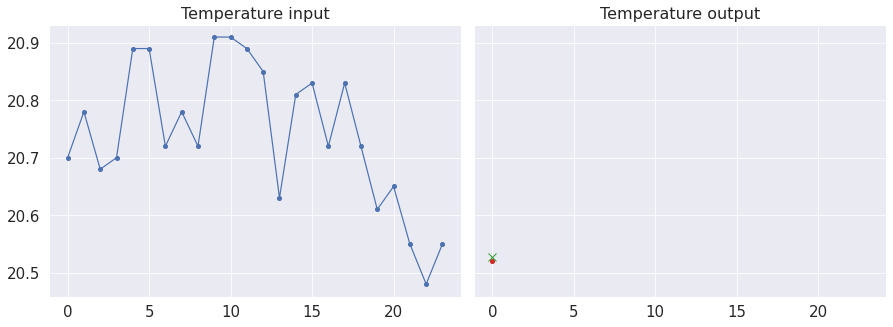

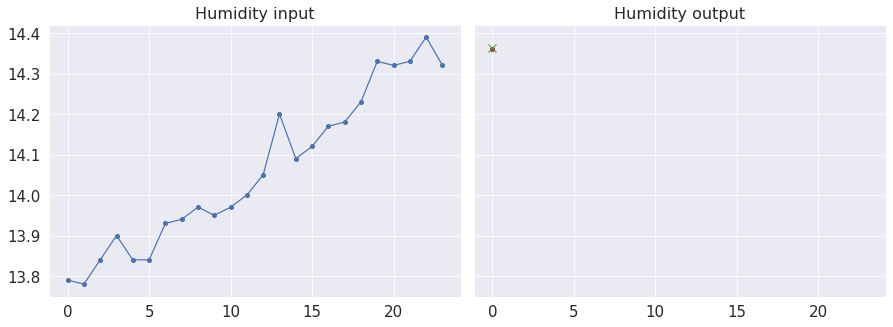

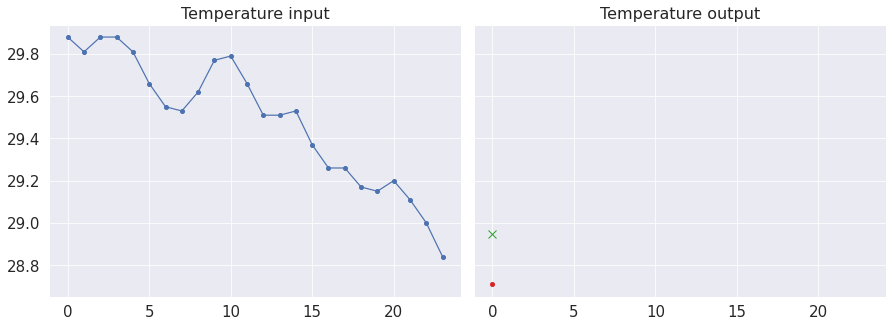

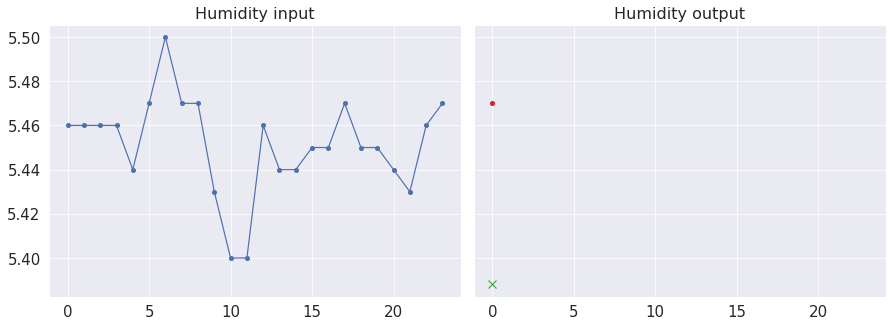

In [41]:
# invert scale
X_test_inv = np.empty(X_real_test.shape)
for s in range(X_real_test.shape[0]): 
  for r in range(X_real_test.shape[1]): 
    X_test_inv[s,r,0] = (X_real_test[s,r,0] - a)*(diff_temp/(b-a)) +(min_temp)
    X_test_inv[s,r,1] = (X_real_test[s,r,1] - a)*(diff_humid/(b-a))+(min_humid)

idx_plot = np.random.randint(X_real_test.shape[0],size=10)
for idx in idx_plot:
  x_input = X_real_test_flat[idx]
  x_input = x_input[np.newaxis,:]
  y_hat_plot = model_real.predict(x_input)

  # invert scale
  y_hat_plot_inv = np.empty(y_hat_plot.shape)
  for s in range(y_hat_plot.shape[0]): 
    y_hat_plot_inv[s,0] = (y_hat_plot[s,0] - a)*(diff_temp/(b-a)) +(min_temp)
    y_hat_plot_inv[s,1] = (y_hat_plot[s,1] - a)*(diff_humid/(b-a))+(min_humid)

  fig,axs = plt.subplots(1,2,sharey=True,sharex=True,figsize=(15,5),
                        gridspec_kw={'wspace': 0.03})
  axs[0].plot(X_test_inv[idx,:,0], marker='.', ms=8)
  axs[0].set_title('Temperature input', fontsize=16)
  axs[1].plot(y_real_test_inv[idx,0], 'tab:red', marker='.', ms=8)
  axs[1].plot(y_hat_plot_inv[:,0], 'tab:green', marker='x', ms=8)
  axs[1].set_title('Temperature output', fontsize=16)
  fig,axs = plt.subplots(1,2,sharey=True,sharex=True,figsize=(15,5),
                        gridspec_kw={'wspace': 0.03})
  axs[0].plot(X_test_inv[idx,:,1], marker='.', ms=8)
  axs[0].set_title('Humidity input', fontsize=16)
  axs[1].plot(y_real_test_inv[idx,1], 'tab:red', marker='.', ms=8)
  axs[1].plot(y_hat_plot_inv[:,1], 'tab:green', marker='x', ms=8)
  axs[1].set_title('Humidity output', fontsize=16)


# Backlog


In [42]:
'''
# load model

model_weights = '/content/drive/My Drive/TFM/Experiments/APIN/lstm_1/lstm_model_1'

model.load_weights(model_weights)
'''

"\n# load model\n\nmodel_weights = '/content/drive/My Drive/TFM/Experiments/APIN/lstm_1/lstm_model_1'\n\nmodel.load_weights(model_weights)\n"

In [43]:
'''
# load data

filename = '/content/drive/My Drive/TFM/Experiments/APIN/lstm_1/X_pred.npy'
X_pred = np.load(filename)
filename = '/content/drive/My Drive/TFM/Experiments/APIN/lstm_1/y_pred.npy'
y_pred = np.load(filename)
filename = '/content/drive/My Drive/TFM/Experiments/APIN/lstm_1/X_val.npy'
X_val = np.load(filename)
filename = '/content/drive/My Drive/TFM/Experiments/APIN/lstm_1/y_val.npy'
y_val = np.load(filename)
filename = '/content/drive/My Drive/TFM/Experiments/APIN/lstm_1/X_test.npy'
X_test = np.load(filename)
filename = '/content/drive/My Drive/TFM/Experiments/APIN/lstm_1/y_test.npy'
y_test = np.load(filename)
'''

"\n# load data\n\nfilename = '/content/drive/My Drive/TFM/Experiments/APIN/lstm_1/X_pred.npy'\nX_pred = np.load(filename)\nfilename = '/content/drive/My Drive/TFM/Experiments/APIN/lstm_1/y_pred.npy'\ny_pred = np.load(filename)\nfilename = '/content/drive/My Drive/TFM/Experiments/APIN/lstm_1/X_val.npy'\nX_val = np.load(filename)\nfilename = '/content/drive/My Drive/TFM/Experiments/APIN/lstm_1/y_val.npy'\ny_val = np.load(filename)\nfilename = '/content/drive/My Drive/TFM/Experiments/APIN/lstm_1/X_test.npy'\nX_test = np.load(filename)\nfilename = '/content/drive/My Drive/TFM/Experiments/APIN/lstm_1/y_test.npy'\ny_test = np.load(filename)\n"

In [44]:
'''
# plot images
for i in range(2):
  for j in range(2):
    fig,axs = plt.subplots(1,2,sharey=True,sharex=True,figsize=(15,5),gridspec_kw={'wspace': 0.03})
    for img in range(n_scenarios):
      axs[0].plot(y_gen_inv_short[i,img,:,j], linestyle='--')
    plt.show()
    plt.close()

# plot images
for i in range(20):
  for j in range(2):
    print(f'{dict_variables[j]}')
    plt.plot(data_gen[i,:,j])
    plt.show()
'''

"\n# plot images\nfor i in range(2):\n  for j in range(2):\n    fig,axs = plt.subplots(1,2,sharey=True,sharex=True,figsize=(15,5),gridspec_kw={'wspace': 0.03})\n    for img in range(n_scenarios):\n      axs[0].plot(y_gen_inv_short[i,img,:,j], linestyle='--')\n    plt.show()\n    plt.close()\n\n# plot images\nfor i in range(20):\n  for j in range(2):\n    print(f'{dict_variables[j]}')\n    plt.plot(data_gen[i,:,j])\n    plt.show()\n"